# Задача 3. Сравнение методов классификации

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

### Задача 
* Взять данные для предсказания заболеваний сердца.
* Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
* Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
* При необходимости выполнить полезные преобразования данных, убрать ненужные признаки, создать новые (Feature Engineering).
* Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
* Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
* Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
* (+3 балла) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rustam-azimov/ml-course-itmo/main/data/heart_disease/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Описание датасета:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

In [3]:
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca', 'thal']
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang']

## EDA

In [4]:
df[num_cols].describe()

,age,trestbps,chol,thalach,oldpeak,slope,ca,thal
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,131.611707,246.00000,149.114146,1.071512,1.385366,0.754146,2.323902
std,9.072290,17.516718,51.59251,23.005724,1.175053,0.617755,1.030798,0.620660
min,29.000000,94.000000,126.00000,71.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.00000,132.000000,0.000000,1.000000,0.000000,2.000000
50%,56.000000,130.000000,240.00000,152.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,140.000000,275.00000,166.000000,1.800000,2.000000,1.000000,3.000000
max,77.000000,200.000000,564.00000,202.000000,6.200000,2.000000,4.000000,3.000000


In [5]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

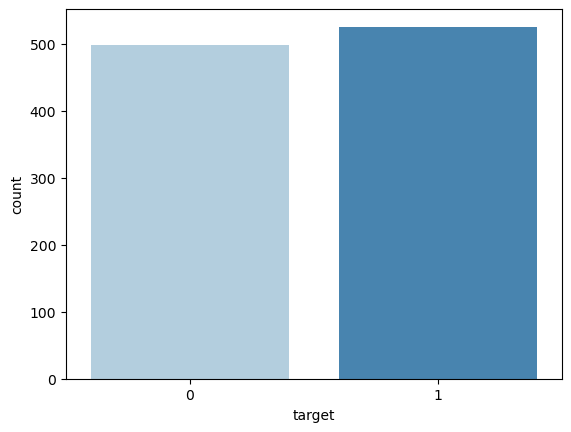

In [6]:
sns.countplot(x='target',data=df,palette='Blues' );

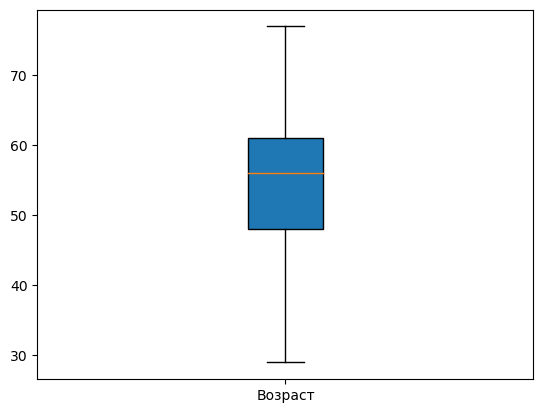

In [7]:
plt.boxplot(df['age'],patch_artist=True, labels=["Возраст"]);

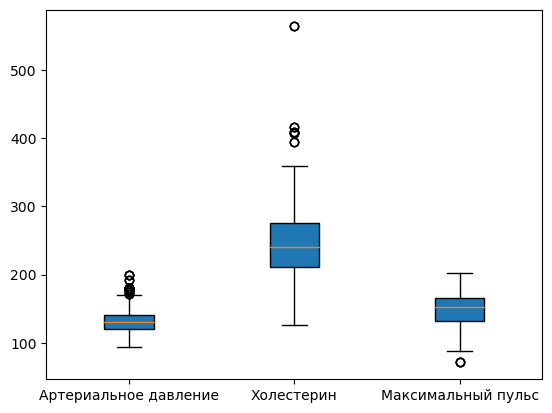

In [8]:
plt.boxplot(df[['trestbps', 'chol', 'thalach']],
            patch_artist=True,
            labels=['Артериальное давление', 'Холестерин', 'Максимальный пульс']);

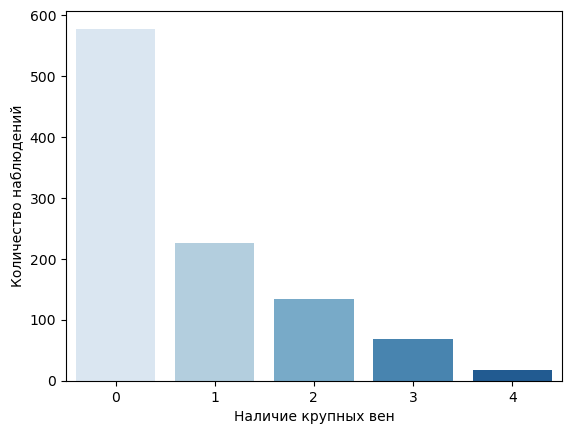

In [9]:
sns.countplot(x='ca',data=df,palette='Blues')
plt.xlabel('Наличие крупных вен')
plt.ylabel('Количество наблюдений')
plt.show()

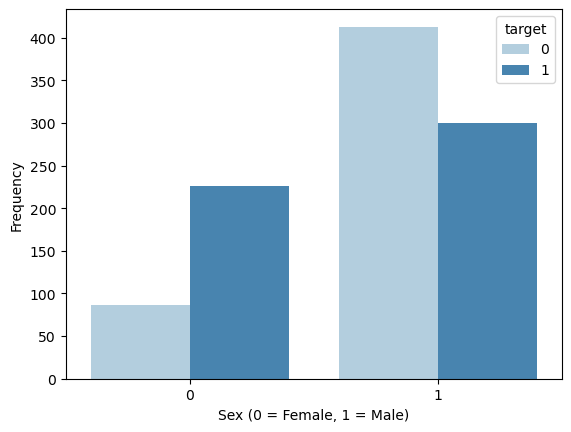

In [10]:
sns.countplot(x='sex', hue='target', data=df,palette='Blues')
plt.ylabel('Frequency')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.show()

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

In [13]:

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13331, stratify=y)

transformer = ColumnTransformer(transformers=[
                                ('num', RobustScaler(), num_cols),
                                ('cat_label', OrdinalEncoder(), cat_cols),
                                ('cat_OH', OneHotEncoder(), cat_cols)])

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_transformed = transformer.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_transformed = transformer.transform(X_test)

In [14]:
from sklearn.model_selection import GridSearchCV

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
accuracies = {}

parameters = {'C':[1, 2, 3, 5]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, n_jobs=-1, cv=10)
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'C': 1}


In [16]:
lr = LogisticRegression(C=1)
lr.fit(X_train_transformed, y_train)

acc = lr.score(X_test_transformed, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy of Logistic Regression {:.4f}".format(acc))

Test Accuracy of Logistic Regression 0.8571


## K-Nearest Neighbour (KNN) Classification

In [17]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':[2, 3, 5], 'leaf_size' : [2, 10, 25]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, n_jobs=-1, cv=10)
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'leaf_size': 2, 'n_neighbors': 2}


In [18]:
knn = KNeighborsClassifier(n_neighbors = 2, leaf_size=2)  # n_neighbors means k
knn.fit(X_train_transformed, y_train)

acc = knn.score(X_test_transformed, y_test)
accuracies['KNN'] = acc

print("Test Accuracy of KNN {:.4f}".format(acc))

Test Accuracy of KNN 0.9416


## Support Vector Machine (SVM)

In [19]:
from sklearn.svm import SVC

parameters = {'C':[5, 10, 15, 25, 35], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}
svm = SVC(random_state = 1331)
clf = GridSearchCV(svm, parameters, n_jobs=-1, cv=10)
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'C': 25, 'kernel': 'rbf'}


In [20]:
svm = SVC(C = 25, kernel='rbf', random_state = 1331)
svm.fit(X_train_transformed, y_train)

acc = svm.score(X_test_transformed, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9708


## Naive Bayes Algorithm

In [21]:
from sklearn.naive_bayes import GaussianNB

parameters = {'var_smoothing': [1e-10, 1e-09, 1e-11]}
nb = GaussianNB()
clf = GridSearchCV(nb, parameters, n_jobs=-1, cv=10)
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'var_smoothing': 1e-10}


In [22]:
nb = GaussianNB(var_smoothing=1e-10)
nb.fit(X_train_transformed, y_train)

acc = nb.score(X_test_transformed, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.8571


## Decision Tree Algorithm

In [23]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ["gini", "entropy"],
              'max_depth':[10, 15, 20],
              'min_samples_split':[2, 4, 8],
              'min_samples_leaf':[1, 4]}
dtc = DecisionTreeClassifier(random_state=1331)
clf = GridSearchCV(dtc, parameters, n_jobs=-1, cv=10, scoring='recall')
clf.fit(X_train, y_train)
print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [24]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=1331)
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9870


In [25]:
for key in accuracies:
    print(key,':', round(accuracies[key], 2))

Logistic Regression : 0.86
KNN : 0.94
SVM : 0.97
Naive Bayes : 0.86
Decision Tree : 0.99


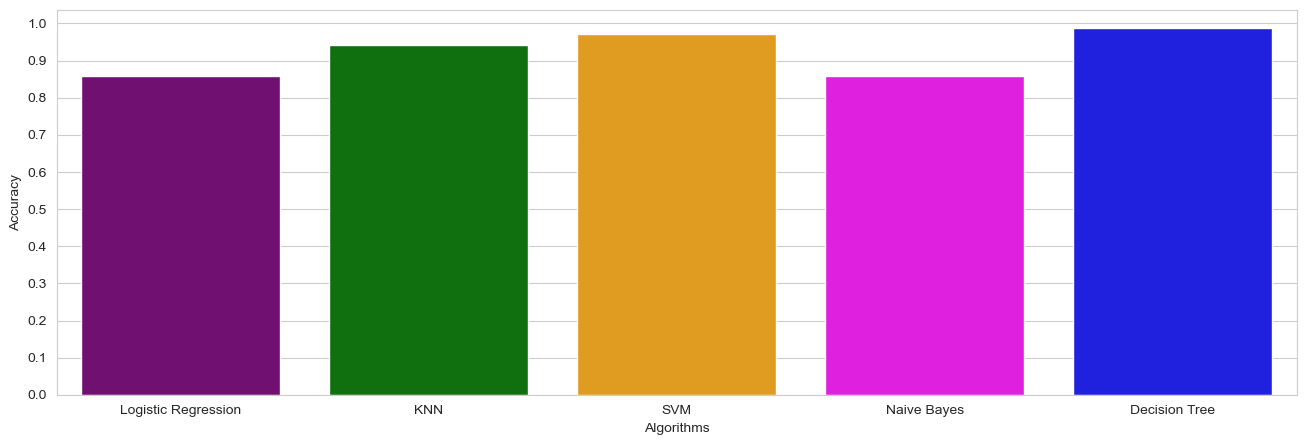

In [26]:
colors = ["purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## Confusion Matrix

In [27]:
# Predicted values
y_head_lr = lr.predict(X_test_transformed)
y_head_knn = knn.predict(X_test_transformed)
y_head_svm = svm.predict(X_test_transformed)
y_head_nb = nb.predict(X_test_transformed)
y_head_dtc = dtc.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

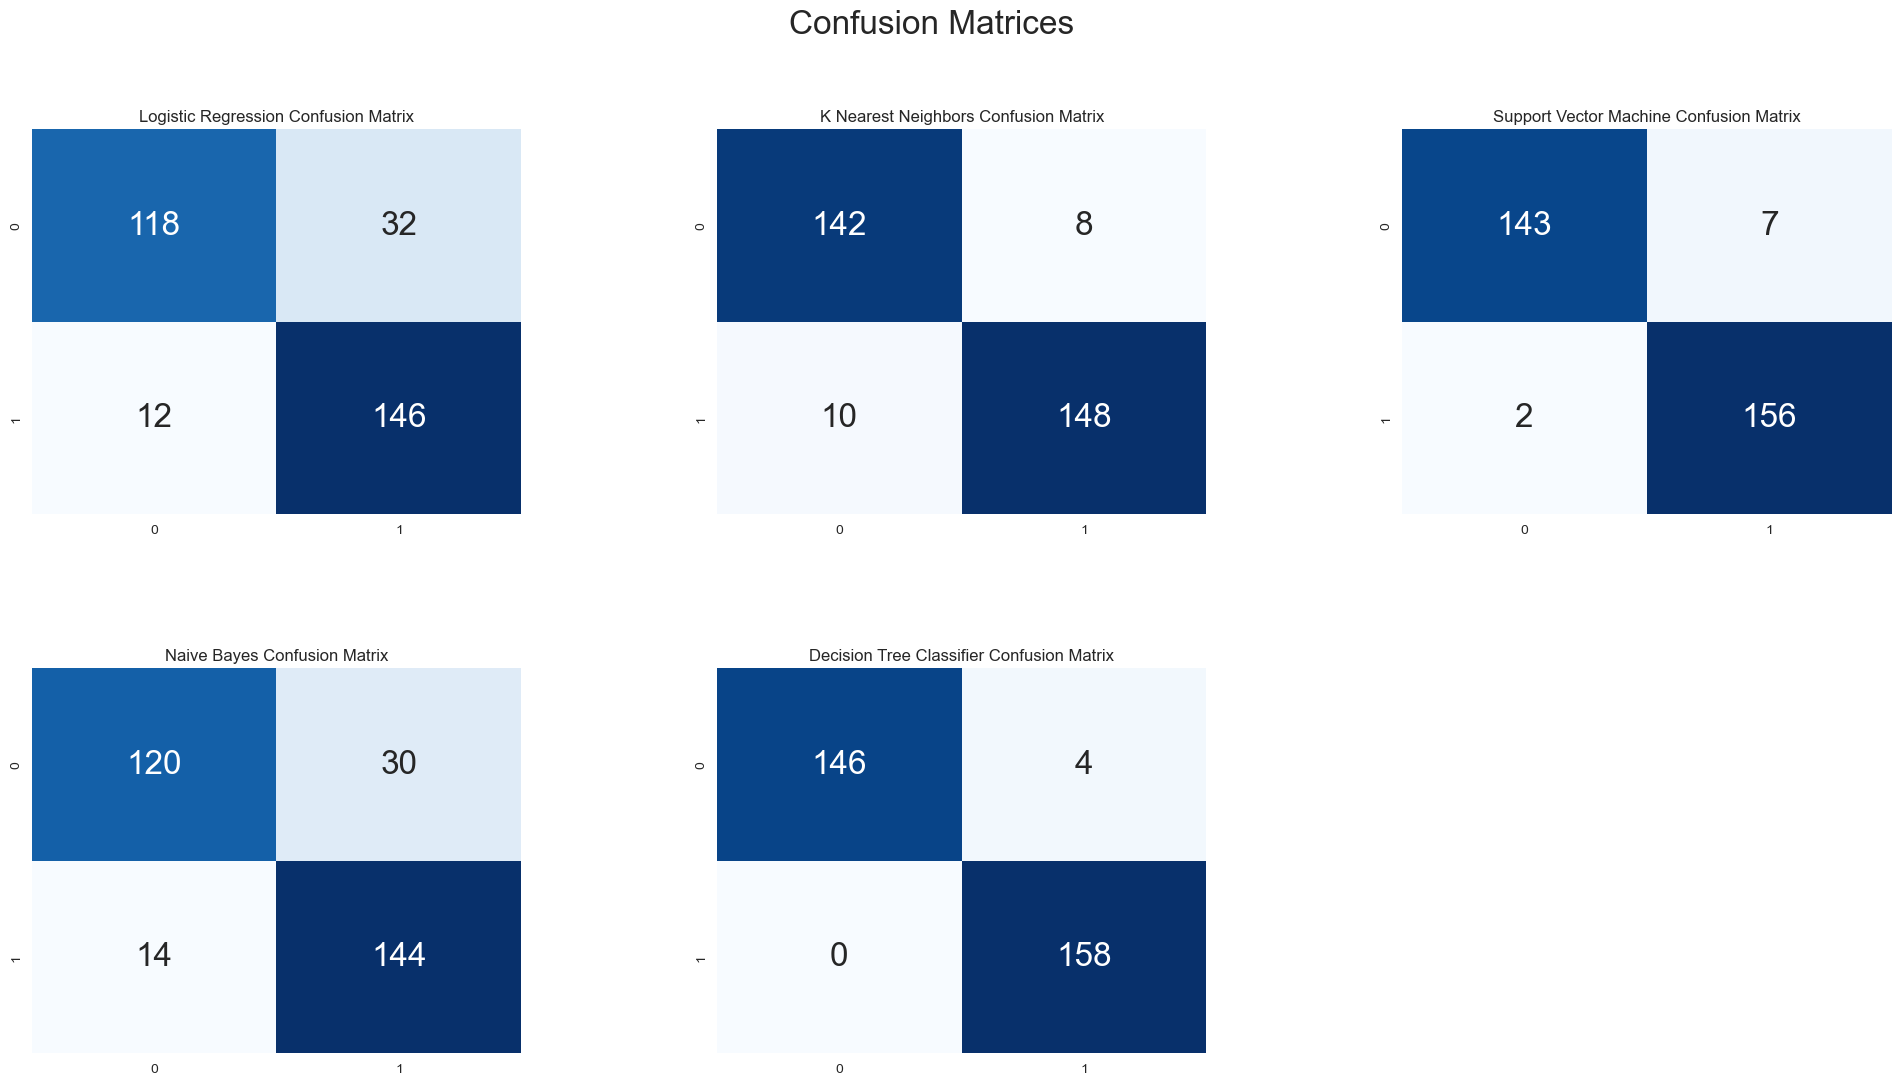

In [29]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Лучше всего справилось с поставленной задачей дерево решений. Предсказания можно было бы улучшить использую случайный лес.

## Датасет - Breast Cancer Dataset
https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset <br>
содержит информацию о параметрах груди и есть ли у человека рак груди <br>

In [30]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [31]:
df.shape

(569, 32)

In [32]:
df.diagnosis.replace({'M': 1, 'B' : 0}, inplace = True)

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

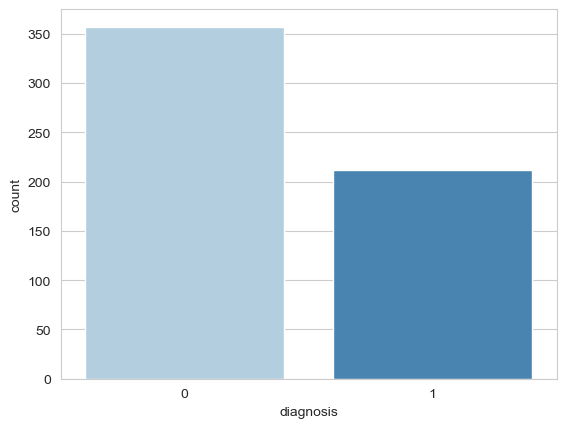

In [33]:
sns.countplot(data = df,x = 'diagnosis', palette='Blues')

<AxesSubplot:xlabel='radius_mean', ylabel='Count'>

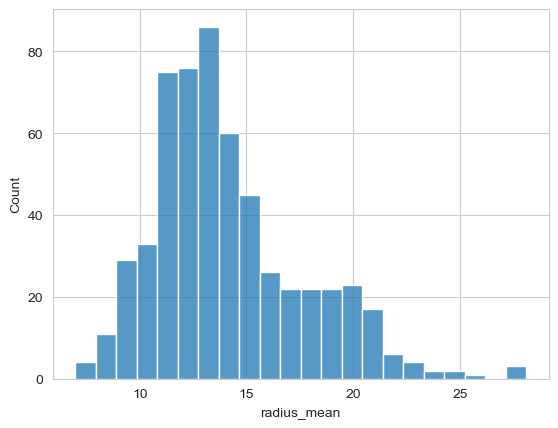

In [34]:
sns.histplot(data = df,x = 'radius_mean', palette='Blues')

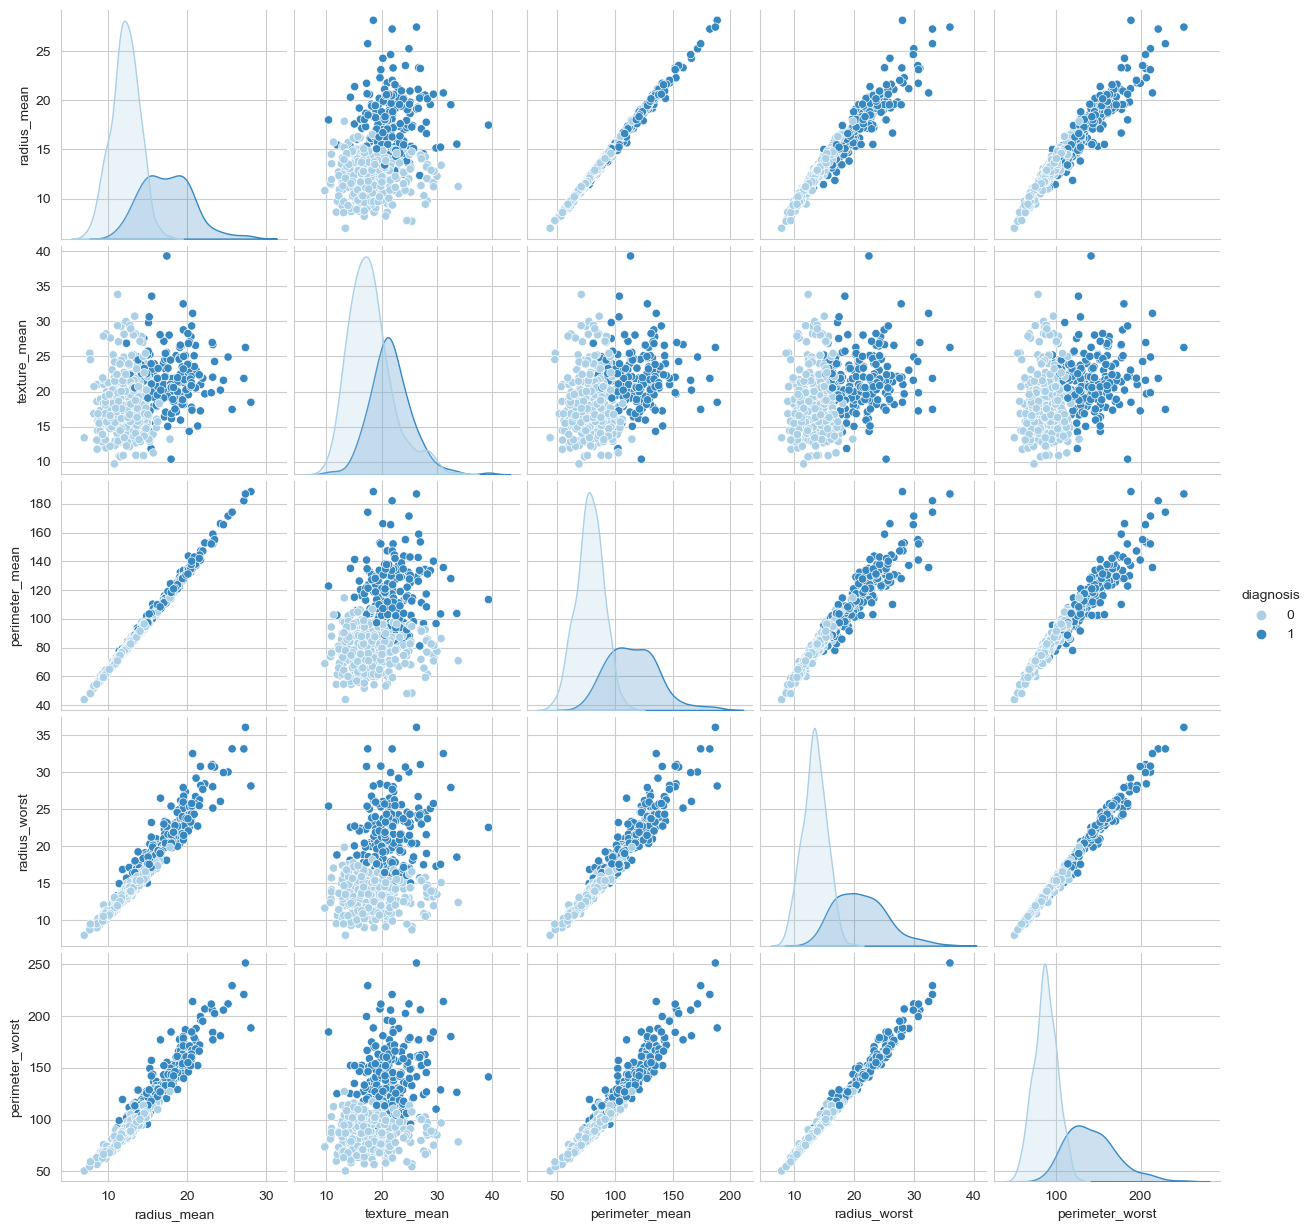

In [35]:
sns.pairplot(df, hue="diagnosis", vars=["radius_mean",
                                        "texture_mean",
                                        "perimeter_mean",
                                        "radius_worst",
                                        "perimeter_worst"], palette='Blues');

Как видно из графиков, рак груди соответствует большим значениям данным. Это объясняется тем, что злокачественное образование при разрастании увеличивает грудь.

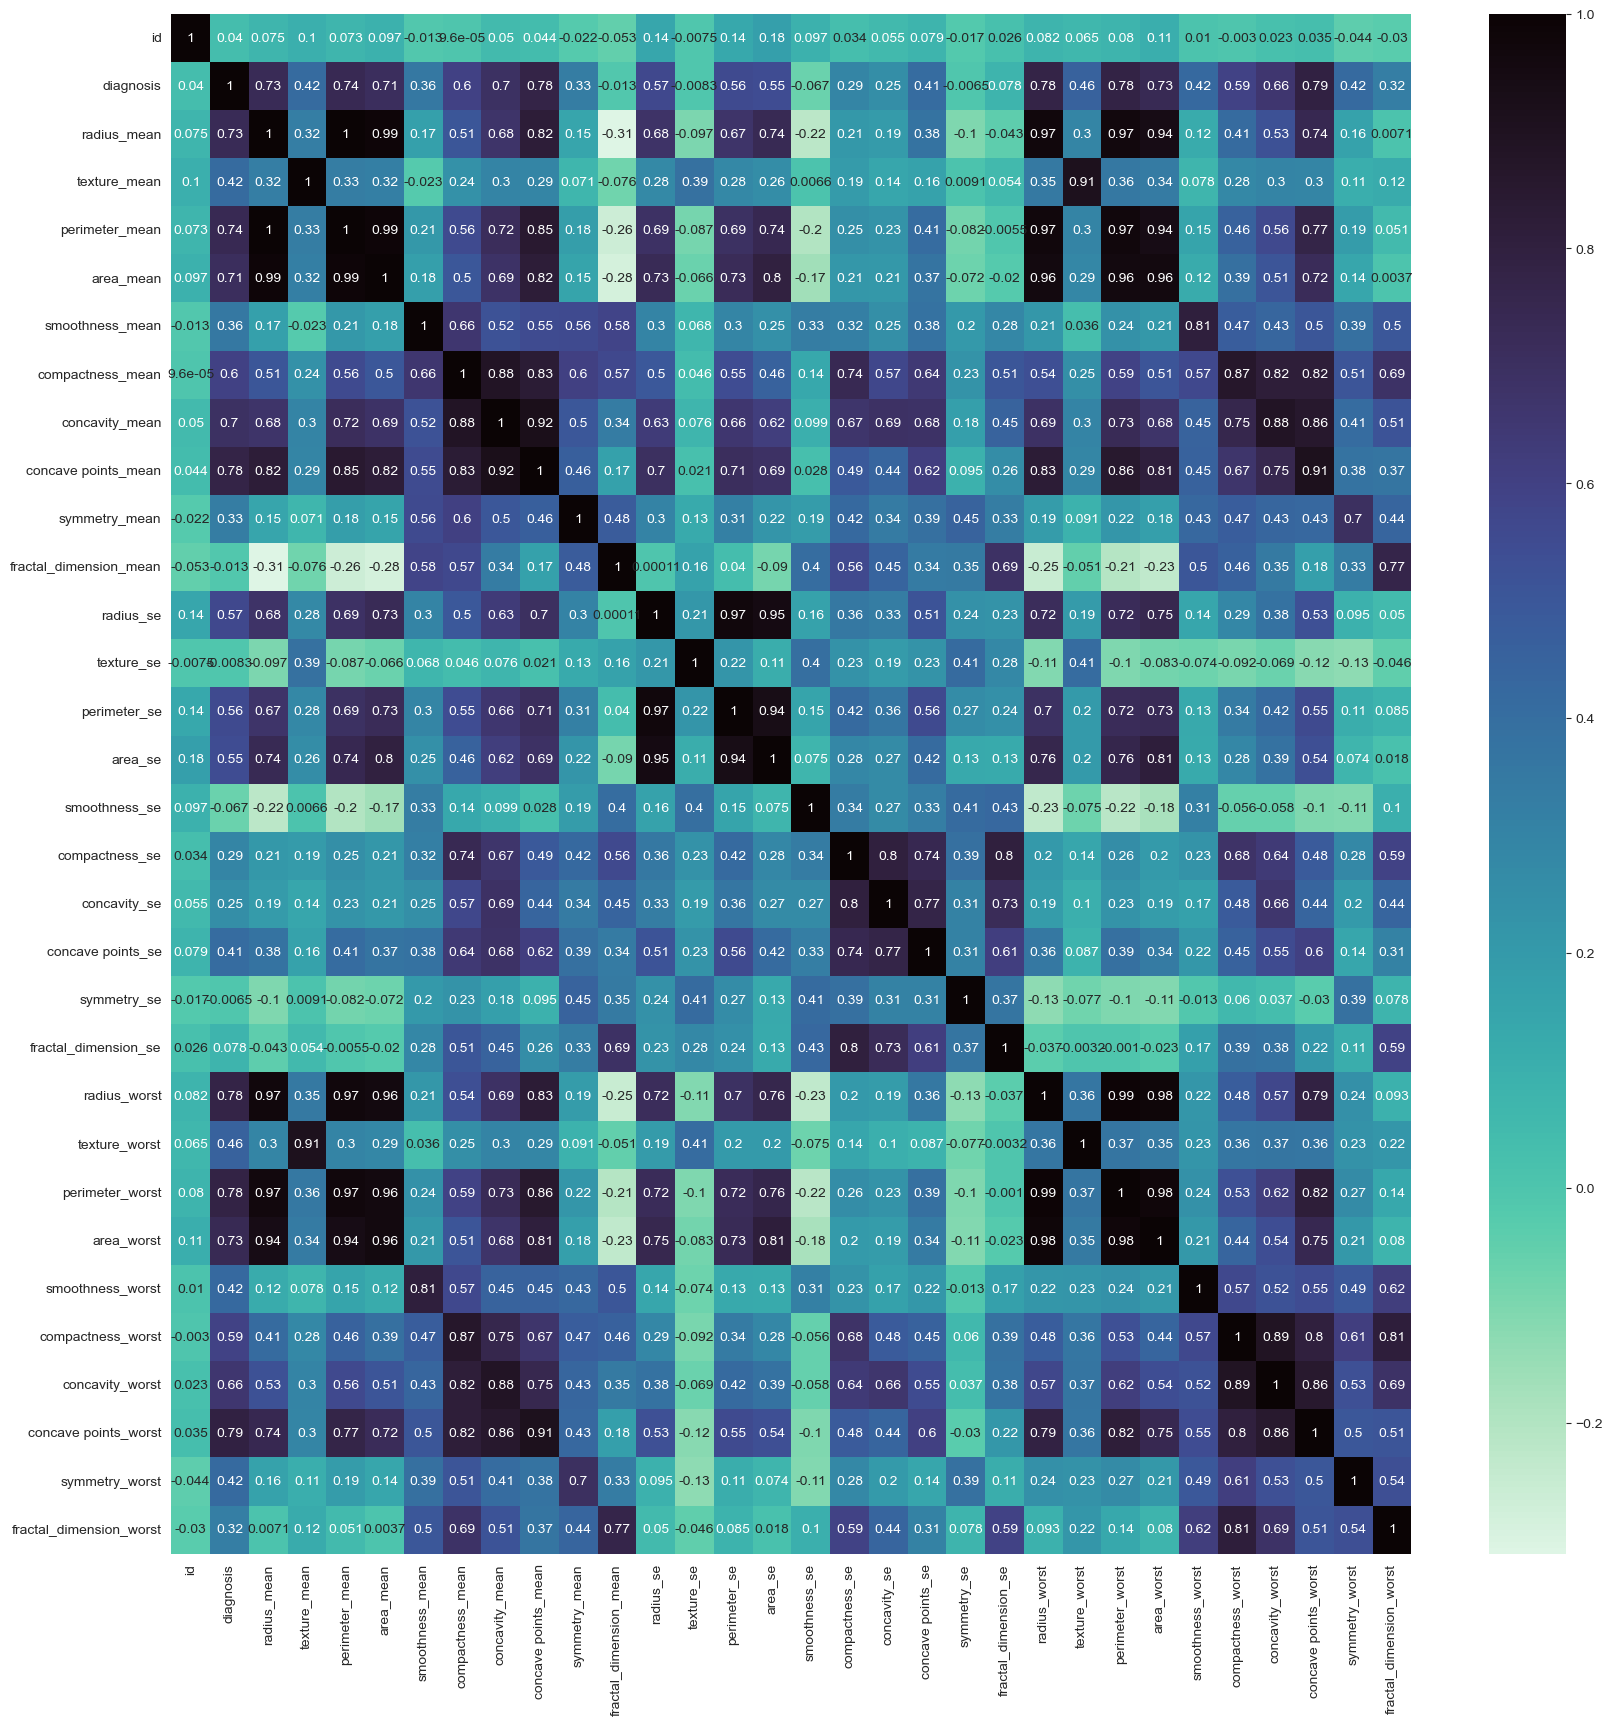

In [36]:
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='mako_r',annot=True)
plt.show()

In [37]:
X = df.drop(['id', 'diagnosis'], axis=1)
y = df.diagnosis

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13331, stratify=y)

Так как данные содержат специфические данные, сложно определить какие из них можно сократить. К тому же многие коррелируют друг с другом. Применим PCA метод чтобы сократить размерность наших данных.

In [39]:
transformer =  RobustScaler()

X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [40]:
from sklearn.decomposition import PCA

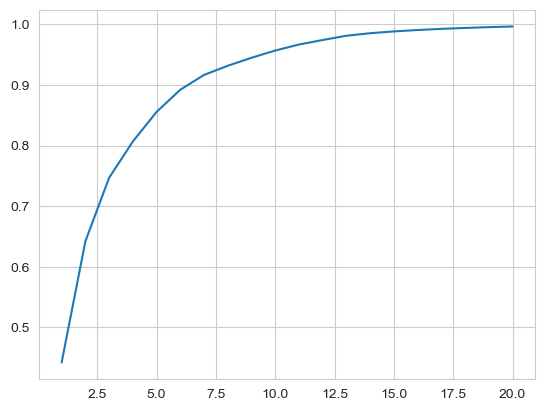

In [41]:
explained_variance = []
for i in range(1, 21):
    pca = PCA(n_components=i)
    pca.fit(X_train_scaled)
    explained_variance.append(sum(pca.explained_variance_ratio_))

plt.plot(range(1, 21), explained_variance);

Достаточно сохранить 10 размерностей чтобы сохранить 95% информации

In [42]:
explained_variance[9]

0.9568851709124608

Так как мы ранее заметили корреляцию между наличием рака и величиной значений данных, попробуем это отобразить на графике

In [43]:
pca = PCA(n_components=2)
simple_X = pca.fit_transform(transformer.fit_transform(X))

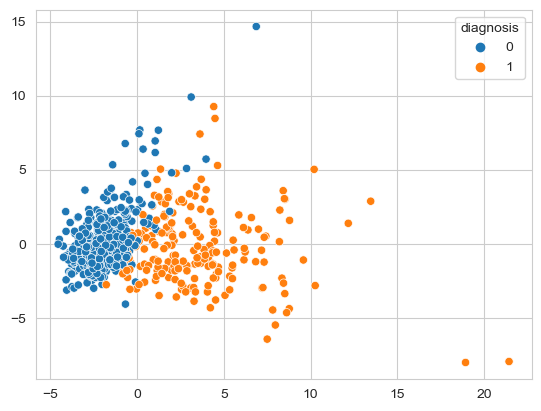

In [62]:
sns.scatterplot(x=simple_X[:, 0], y=simple_X[:, 1], hue=y);

Такой график сложно интерпретировать так как мы не знаем точно какие данные отображаем. Но видно, что данные хорошо отделимы и можно провести разделяющую плоскость.

In [45]:
pca = PCA(n_components=10)

In [46]:
X_train_transformed = pca.fit_transform(X_train_scaled)

X_test_transformed = pca.transform(X_test_scaled)

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
accuracies = {}

parameters = {'C':range(1, 20, 2)}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, n_jobs=-1, cv=10, scoring='recall')
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'C': 9}


In [48]:
lr = LogisticRegression(C=9)
lr.fit(X_train_transformed, y_train)

acc = lr.score(X_test_transformed, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.9766


## K-Nearest Neighbour (KNN) Classification

In [49]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':range(2, 10, 2), 'leaf_size' : range(2, 10, 2)}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, n_jobs=-1, cv=10, scoring='recall')
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'leaf_size': 2, 'n_neighbors': 4}


In [50]:
knn = KNeighborsClassifier(n_neighbors = 4, leaf_size=2)  # n_neighbors means k
knn.fit(X_train_transformed, y_train)

acc = knn.score(X_test_transformed, y_test)
accuracies['KNN'] = acc

print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.9591


## Support Vector Machine (SVM)

In [51]:
from sklearn.svm import SVC

parameters = {'C':range(1, 30, 5), 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}
svm = SVC(random_state = 1331)
clf = GridSearchCV(svm, parameters, n_jobs=-1, cv=10, scoring='recall')
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'C': 6, 'kernel': 'linear'}


In [52]:
svm = SVC(C = 6, kernel='linear', random_state = 1331)
svm.fit(X_train_transformed, y_train)

acc = svm.score(X_test_transformed, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9708


## Naive Bayes Algorithm

In [53]:
from sklearn.naive_bayes import GaussianNB

parameters = {'var_smoothing': [1e-10, 1e-09, 1e-11]}
nb = GaussianNB()
clf = GridSearchCV(nb, parameters, n_jobs=-1, cv=10, scoring='recall')
clf.fit(X_train_transformed, y_train)
print(clf.best_params_)

{'var_smoothing': 1e-10}


In [54]:
nb = GaussianNB(var_smoothing=1e-10)
nb.fit(X_train_transformed, y_train)

acc = nb.score(X_test_transformed, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.8889


## Decision Tree Algorithm

In [55]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ["gini", "entropy"],
              'max_depth':range(5, 21, 5),
              'min_samples_split':range(2, 11, 2),
              'min_samples_leaf':range(1, 11, 2)}
dtc = DecisionTreeClassifier(random_state=1331)
clf = GridSearchCV(dtc, parameters, n_jobs=-1, cv=10, scoring='recall')
clf.fit(X_train, y_train)
print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6}


In [56]:
dtc = DecisionTreeClassifier(criterion='entropy',
                             max_depth=10,
                             min_samples_leaf = 1,
                             min_samples_split = 6,
                             random_state=1331)
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.9357


In [57]:
for key in accuracies:
    print(key,':', round(accuracies[key], 2))

Logistic Regression : 0.98
KNN : 0.96
SVM : 0.97
Naive Bayes : 0.89
Decision Tree : 0.94


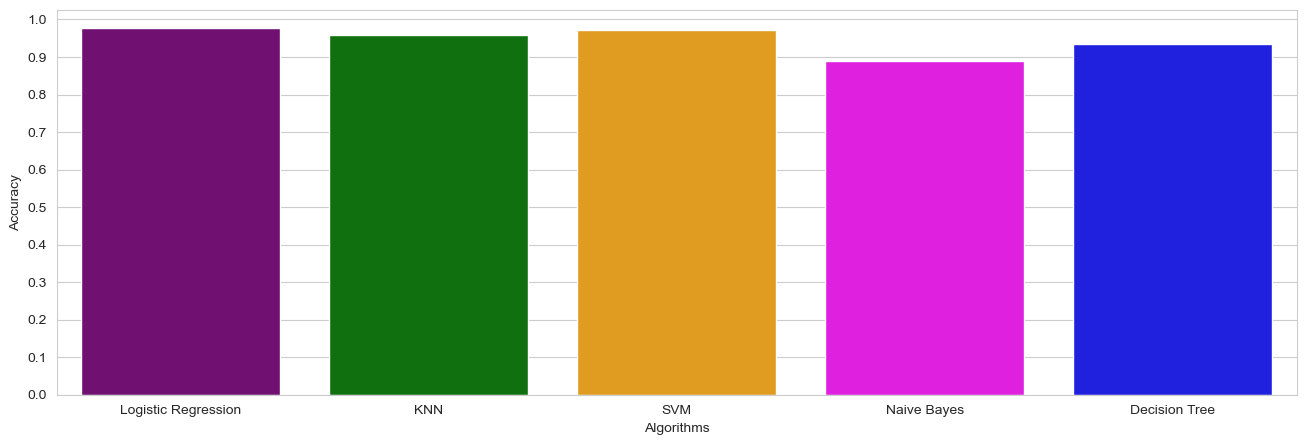

In [58]:
colors = ["purple", "green", "orange", "magenta", "blue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## Confusion Matrix

In [59]:
# Predicted values
y_head_lr = lr.predict(X_test_transformed)
y_head_knn = knn.predict(X_test_transformed)
y_head_svm = svm.predict(X_test_transformed)
y_head_nb = nb.predict(X_test_transformed)
y_head_dtc = dtc.predict(X_test)

In [60]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

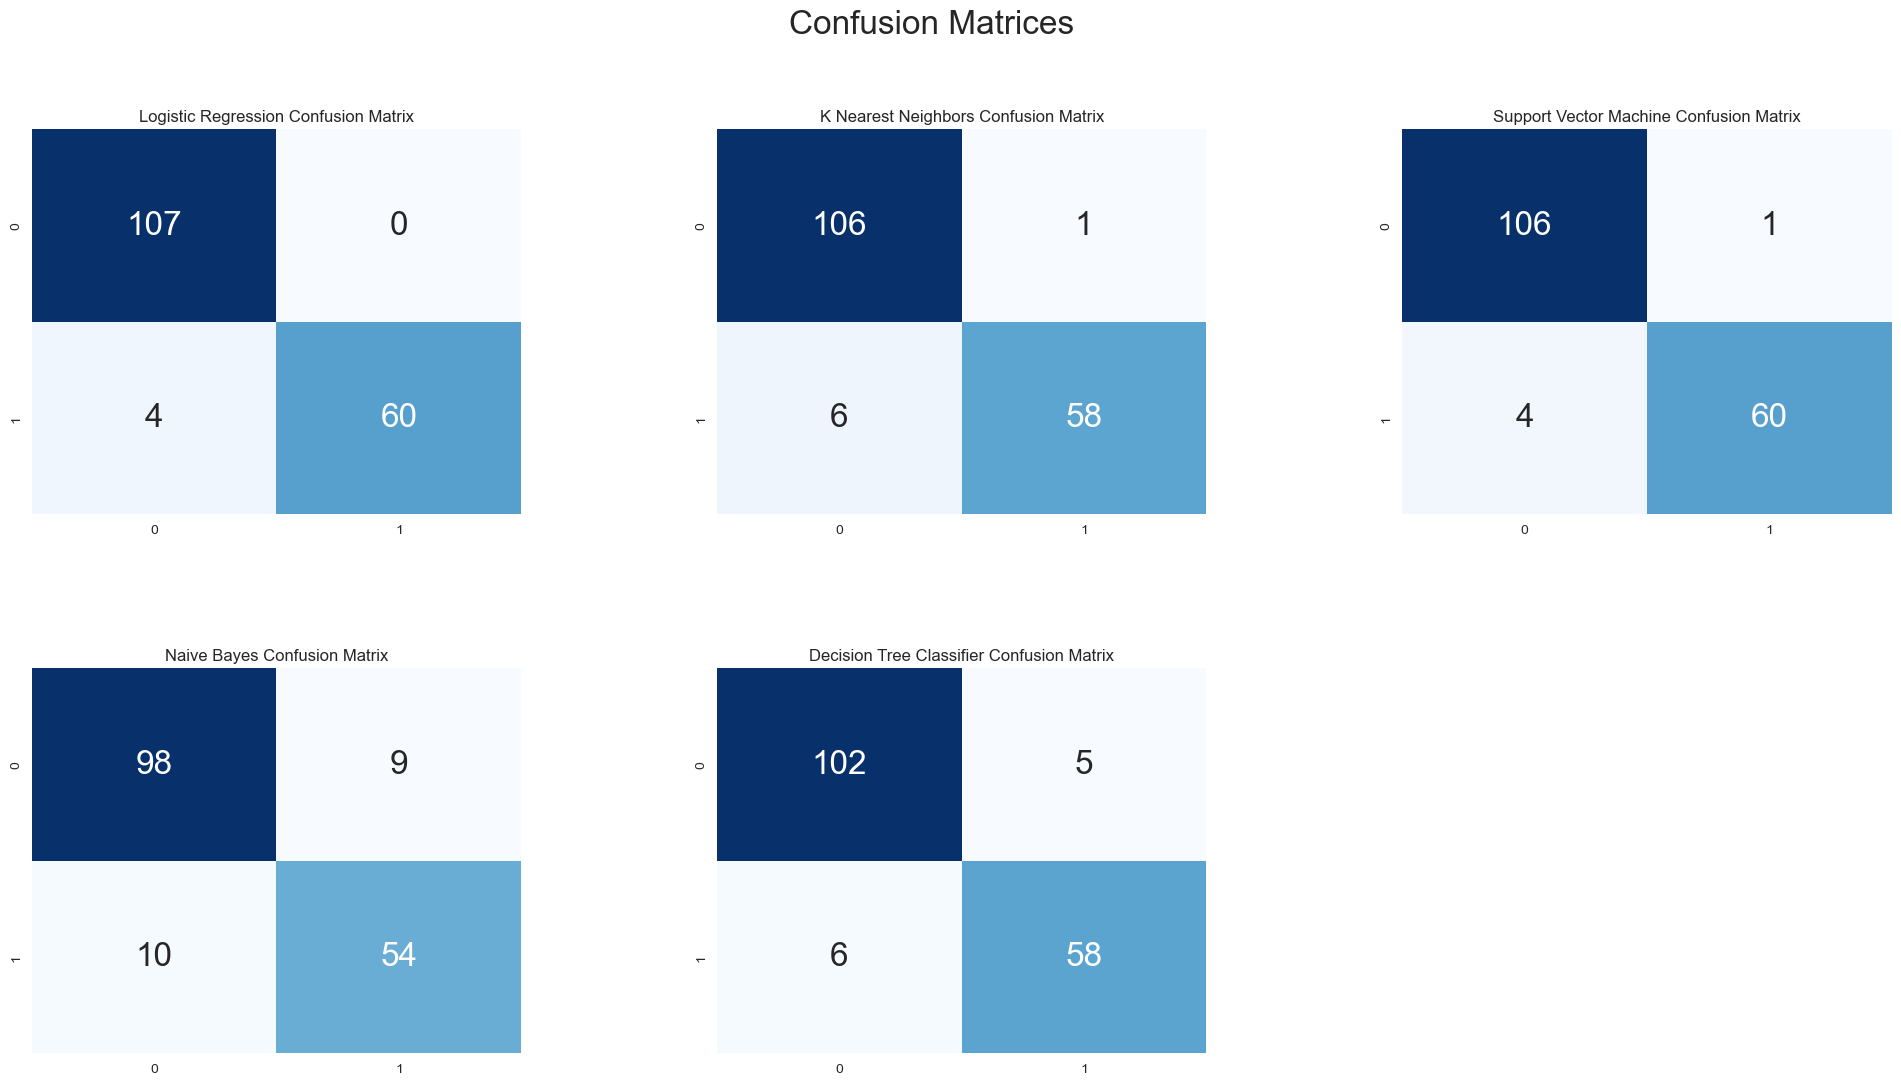

In [61]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

Лучшим алгоритмом оказалась линейная регрессия. Это не удивительно, так как мы ранее отметили что данные линейно разделимы.